### Topic Analysis using Top2Vec (Community Dataset #1: 01/09/2020 - 15/12/2020)

#### Import core libraries

In [10]:
# Import Core library
import sys
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, nltk
import openpyxl
import emoji
from pprint import pprint
from cleantext import clean
import little_mallet_wrapper
from top2vec import Top2Vec

In [11]:
# Import Dataset
df = pd.read_excel('../Community306_raw.xlsx')

In [12]:
df.head(3)

Unnamed: 0            id  source_id          created_at geo_source  \
0           1  1.346170e+18         18 2021-01-04 19:01:23          1   
1           3  1.345954e+18         18 2021-01-04 04:45:23       None   
2           4  1.345954e+18         18 2021-01-04 04:45:13       None   

   truncated                                               text  \
0          0  @HHere4trump @sbacon0410 #stopthesteal #stopth...   
1          0  @RudyGiuliani @CaliConserv1 #StoptheSteal #Sto...   
2          0  #StoptheSteal #StoptheSteal #StoptheSteal #Sto...   

  text_sentiment text_toxicity lang  ...  retweet_id_str  is_quote_status  \
0           None          None  und  ...            None                0   
1           None          None  und  ...            None                0   
2           None          None  und  ...            None                0   

   quoted_status_id_str  in_reply_to_status_id_str  in_reply_to_user_id_str  \
0                  None        1346156649287987201                     None   
1                  None        1345924505483546624                     None   
2   1345924505483546624                       None                     None   

   in_reply_to_screen_name                                           entities  \
0                     None  {"entities": {"hashtags": [{"end": 38, "tag": ...   
1                     None  {"entities": {"hashtags": [{"end": 41, "tag": ...   
2                     None  {"entities": {"urls": [{"end": 303, "url": "ht...   

   possibly_sensitive coordinates place  
0                   0        None  None  
1                   0        None  None  
2                   0        None  None  

[3 rows x 26 columns]

In [13]:
df['text'].head(3)

0    @HHere4trump @sbacon0410 #stopthesteal #stopth...
1    @RudyGiuliani @CaliConserv1 #StoptheSteal #Sto...
2    #StoptheSteal #StoptheSteal #StoptheSteal #Sto...
Name: text, dtype: object

In [33]:
df['create_year'] = pd.to_datetime(df.created_at, format='%m/%d/%Y', errors='coerce')
df['year'] = pd.to_datetime(df.created_at).dt.strftime('%Y')
df['month'] = pd.to_datetime(df.created_at).dt.strftime('%m')

In [34]:
start_date = "09/01/2020"
end_date = "12/15/2020"
after_start_date = df['create_year'] > start_date
before_end_date = df['create_year'] < end_date
between_two_dates = after_start_date & before_end_date

stream_one = df.loc[between_two_dates]

In [16]:
stream_one.head(3)

Unnamed: 0            id  source_id          created_at geo_source  \
43814      124741  1.300607e+18         18 2020-09-01 01:32:22       None   
43815      124742  1.300612e+18         18 2020-09-01 01:49:48       None   
43816      124744  1.300612e+18         18 2020-09-01 01:52:14       None   

       truncated                                        text text_sentiment  \
43814          0  #StopTheSteal 2020 https://t.co/0eGlgNMmpS           None   
43815          0       #StopTheSteal https://t.co/1iBSanqHp7           None   
43816          0               RT @MeryRobins: #StopTheSteal           None   

      text_toxicity lang  ...  in_reply_to_status_id_str  \
43814          None  und  ...                       None   
43815          None  und  ...                       None   
43816          None  und  ...                       None   

       in_reply_to_user_id_str  in_reply_to_screen_name  \
43814                     None                     None   
43815                     None                     None   
43816                     None                     None   

                                                entities  possibly_sensitive  \
43814  {"entities": {"urls": [{"end": 42, "url": "htt...                   0   
43815  {"entities": {"urls": [{"end": 37, "url": "htt...                   0   
43816  {"entities": {"hashtags": [{"end": 29, "tag": ...                   0   

       coordinates                             place         create_year  \
43814         None                              None 2020-09-01 01:32:22   
43815         None  {"place_id": "dc96a032c98a1ea9"} 2020-09-01 01:49:48   
43816         None                              None 2020-09-01 01:52:14   

       year month  
43814  2020    09  
43815  2020    09  
43816  2020    09  

[3 rows x 29 columns]

In [35]:
stream_one['create_year']

43814    2020-09-01 01:32:22
43815    2020-09-01 01:49:48
43816    2020-09-01 01:52:14
43817    2020-09-01 14:03:22
43818    2020-09-01 16:18:51
                 ...        
296031   2020-12-14 23:57:34
296032   2020-12-14 23:58:07
296033   2020-12-14 23:58:20
296034   2020-12-14 23:58:53
296035   2020-12-14 23:59:45
Name: create_year, Length: 252222, dtype: datetime64[ns]

In [18]:
# Export streamline dataset as excel file
stream_one.to_excel(r"C:\Users\Ivory-UALR\Documents\COSMOS\Billy's Project\community_topic_model\stream_one.xlsx")

#### Process Corpus Dataset

In [19]:
# Function to remove twitter specific characters
def get_url_patern():
    return re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')

def get_hashtags_pattern():
    return re.compile(r'#\w*')

def get_single_letter_words_pattern():
    return re.compile(r'(?<![\w\-])\w(?![\w\-])')

def get_blank_spaces_pattern():
    return re.compile(r'\s{2,}|\t')

def get_twitter_reserved_words_pattern():
    return re.compile(r'(RT|rt|FAV|fav|VIA|via)')

def get_mentions_pattern():
    return re.compile(r'@\w*')

def process_text(word):
  word=re.sub(pattern=get_url_patern(), repl="", string=word)
  word=re.sub(pattern=get_mentions_pattern(), repl="", string=word)
  word=re.sub(pattern=get_hashtags_pattern(), repl="", string=word)
  word=re.sub(pattern=get_twitter_reserved_words_pattern(), repl='', string=word)
  word=re.sub(r'http\S+', "", word)  # remove http links
  word=re.sub(r'bit.ly/\S+', "", word)  # rempve bitly links
  word=word.strip('[link]')  # remove [links]
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove retweet
  word=re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove tweeted at
  word=clean(word, no_emoji=True)
  return word

In [20]:
# Remove twitter specific characters
stream_one.text = stream_one.apply(lambda row: process_text(row.text), 1)

C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
# Remove punctuations, stop words, digits and turn text to lowercase
training_data = [little_mallet_wrapper.process_string(text, numbers='remove') for text in stream_one.text]

#### Build Top2Vec Model

In [22]:
model = Top2Vec(training_data)

2022-03-26 08:20:07,178 - top2vec - INFO - Pre-processing documents for training
2022-03-26 08:20:11,980 - top2vec - INFO - Creating joint document/word embedding
2022-03-26 08:26:43,270 - top2vec - INFO - Creating lower dimension embedding of documents
2022-03-26 08:30:19,759 - top2vec - INFO - Finding dense areas of documents
2022-03-26 08:30:38,408 - top2vec - INFO - Finding topics


In [23]:
model.get_num_topics()

1823

In [24]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [25]:
# Get topic words, word scores and topic numbers
topic_words, word_scores, topic_nums = model.get_topics(77)

In [26]:
model.topic_words[0]

array(['fewer', 'assembled', 'incredible', 'harrisburg', 'nhk', 'hours',
       'peacefully', 'harrisburgh', 'across', 'reince', 'pennsylvania',
       'congressmen', 'pueblo', 'electric', 'washingto', 'grit',
       'briankempga', 'anthem', 'carpedonktum', 'nuff', 'pilot',
       'sacramento', 'overlooking', 'calles', 'undermined', 'corey',
       'georiga', 'mas', 'capitals', 'marches', 'heider', 'colorado',
       'abnormally', 'leaked', 'columbia', 'stp', 'las', 'chants',
       'guiliani', 'mounts', 'marine', 'huntington', 'nashville', 'orgy',
       'depament', 'wil', 'beverly', 'magamarch', 'madison', 'wrongfully'],
      dtype='<U15')

#### Visualize Topic Distribution and Keywords

In [27]:
topic_dist = pd.DataFrame()

for topic_number in topic_nums:
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_number, num_docs=1)
    topic_dist = topic_dist.append(pd.Series([topic_number, model.topic_words[topic_number]]), ignore_index=True)
    
topic_dist.columns = ['Topic_Number', 'Topic_Words']

In [28]:
top_10_dist = topic_dist.head(10)
top_10_dist

Topic_Number                                        Topic_Words
0           0.0  [fewer, assembled, incredible, harrisburg, nhk...
1           1.0  [congressmen, harrisburg, joined, building, gr...
2           2.0  [wrongfully, prevented, entering, watcher, pol...
3           3.0  [stp, studio, seeing, mounts, stel, letsgo, co...
4           4.0  [sotus, legitimate, electric, orgy, accept, st...
5           5.0  [carpedonktum, wrongfully, gressman, happen, w...
6           6.0  [stp, potu, stel, harrisburgh, awesome, studio...
7           7.0  [acknowledges, grit, scathing, transitions, so...
8           8.0  [briankempga, harrisburgh, studio, congressmen...
9           9.0  [congressmen, harrisburg, building, harrisburg...

In [29]:
# Export topics attached to top 10 original tweets as excel file
top_10_dist.to_excel(r"C:\Users\Ivory-UALR\Documents\COSMOS\Billy's Project\community_topic_model\1st_community_dataset\topics_top10_tweets_1st_analysis.xlsx")

In [30]:
topics_10 = topic_nums[:10]

In [31]:
for topic in topics_10:
    topics = []
    topics.append(model.search_documents_by_topic(topic, num_docs=1))
    print(topics)

[(array(['incredible fewer hours people across pennsylvania peacefully assembled harrisburg'],
      dtype=object), array([0.987183], dtype=float32), array([50336]))]
[(array(['joined congressmen harrisburg capitol building'], dtype=object), array([0.9870978], dtype=float32), array([42552]))]
[(array(['poll watcher philly wrongfully prevented entering polling place'],
      dtype=object), array([0.9892005], dtype=float32), array([6394]))]
[(array(['tell seeing repo case call'], dtype=object), array([0.9887404], dtype=float32), array([68863]))]
[(array(['never accept stolen election right legitimate votes counted stand president'],
      dtype=object), array([0.9765573], dtype=float32), array([170078]))]
[(array(['democrats trying steal election won let happen'], dtype=object), array([0.98433286], dtype=float32), array([31834]))]
[(array(['awesome governor'], dtype=object), array([0.9943771], dtype=float32), array([177028]))]
[(array(['election force cheat'], dtype=object), array([0.991

#### Word cloud visualization for Community Dataset #1

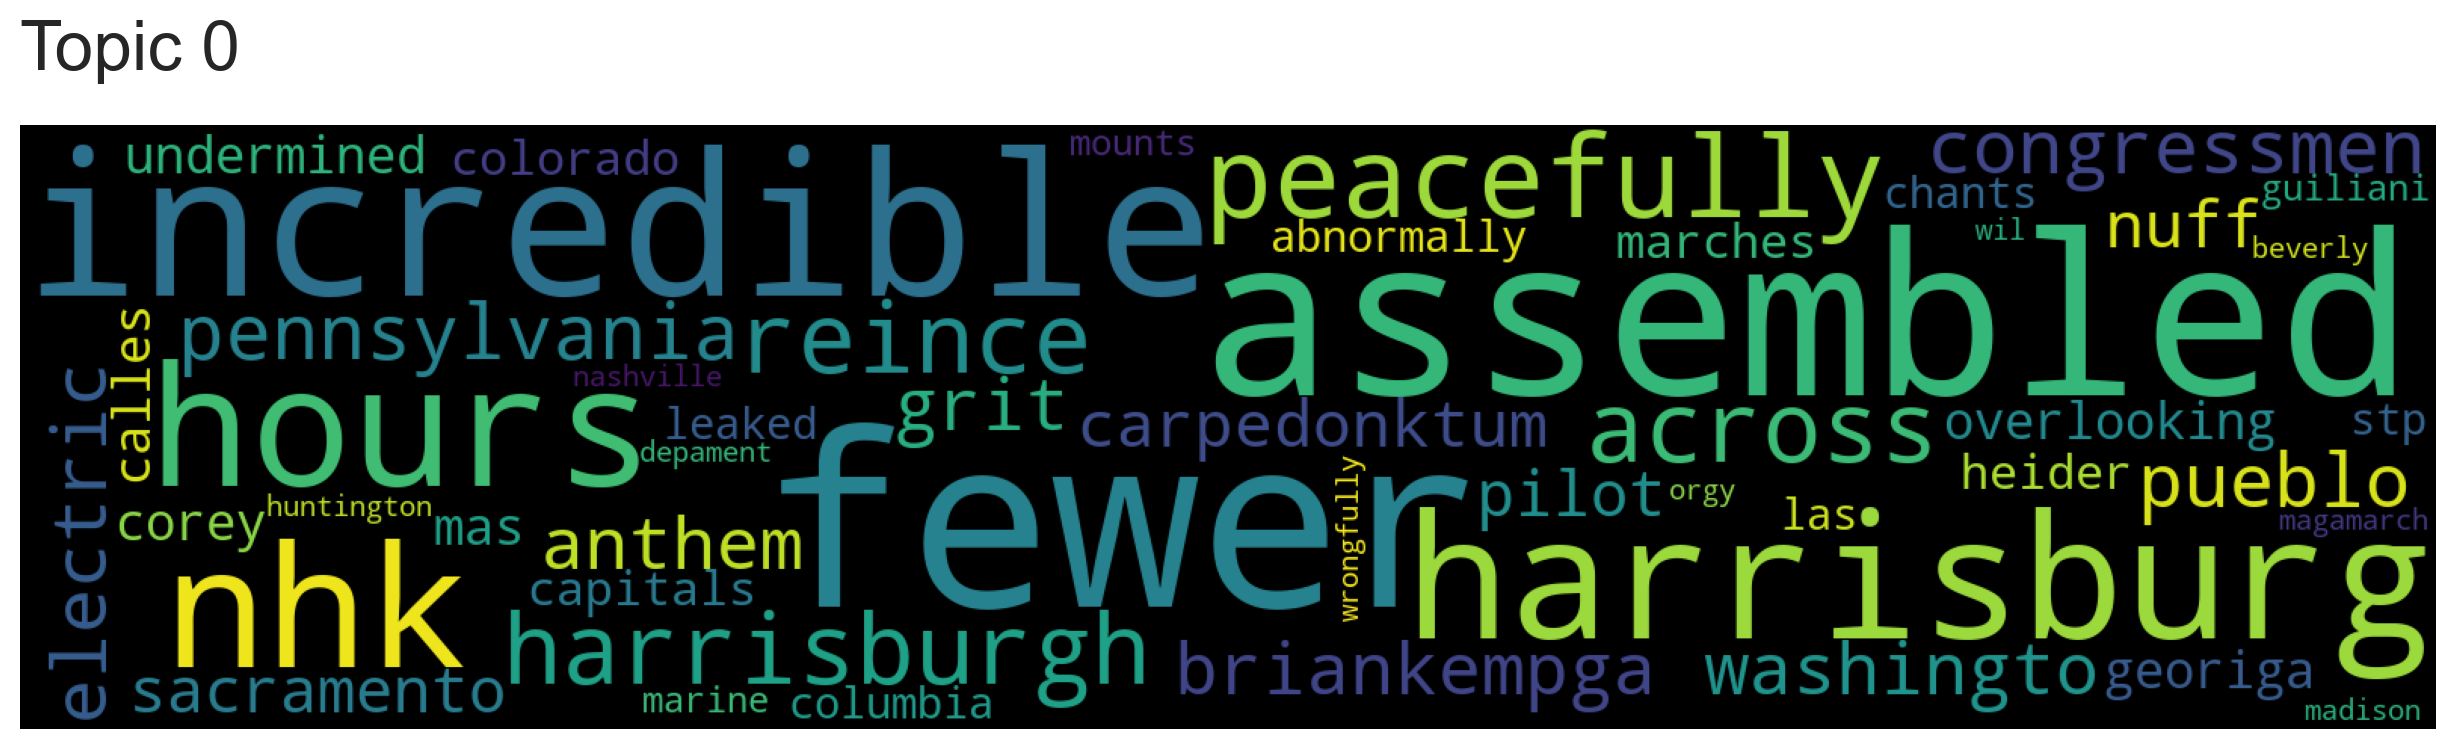

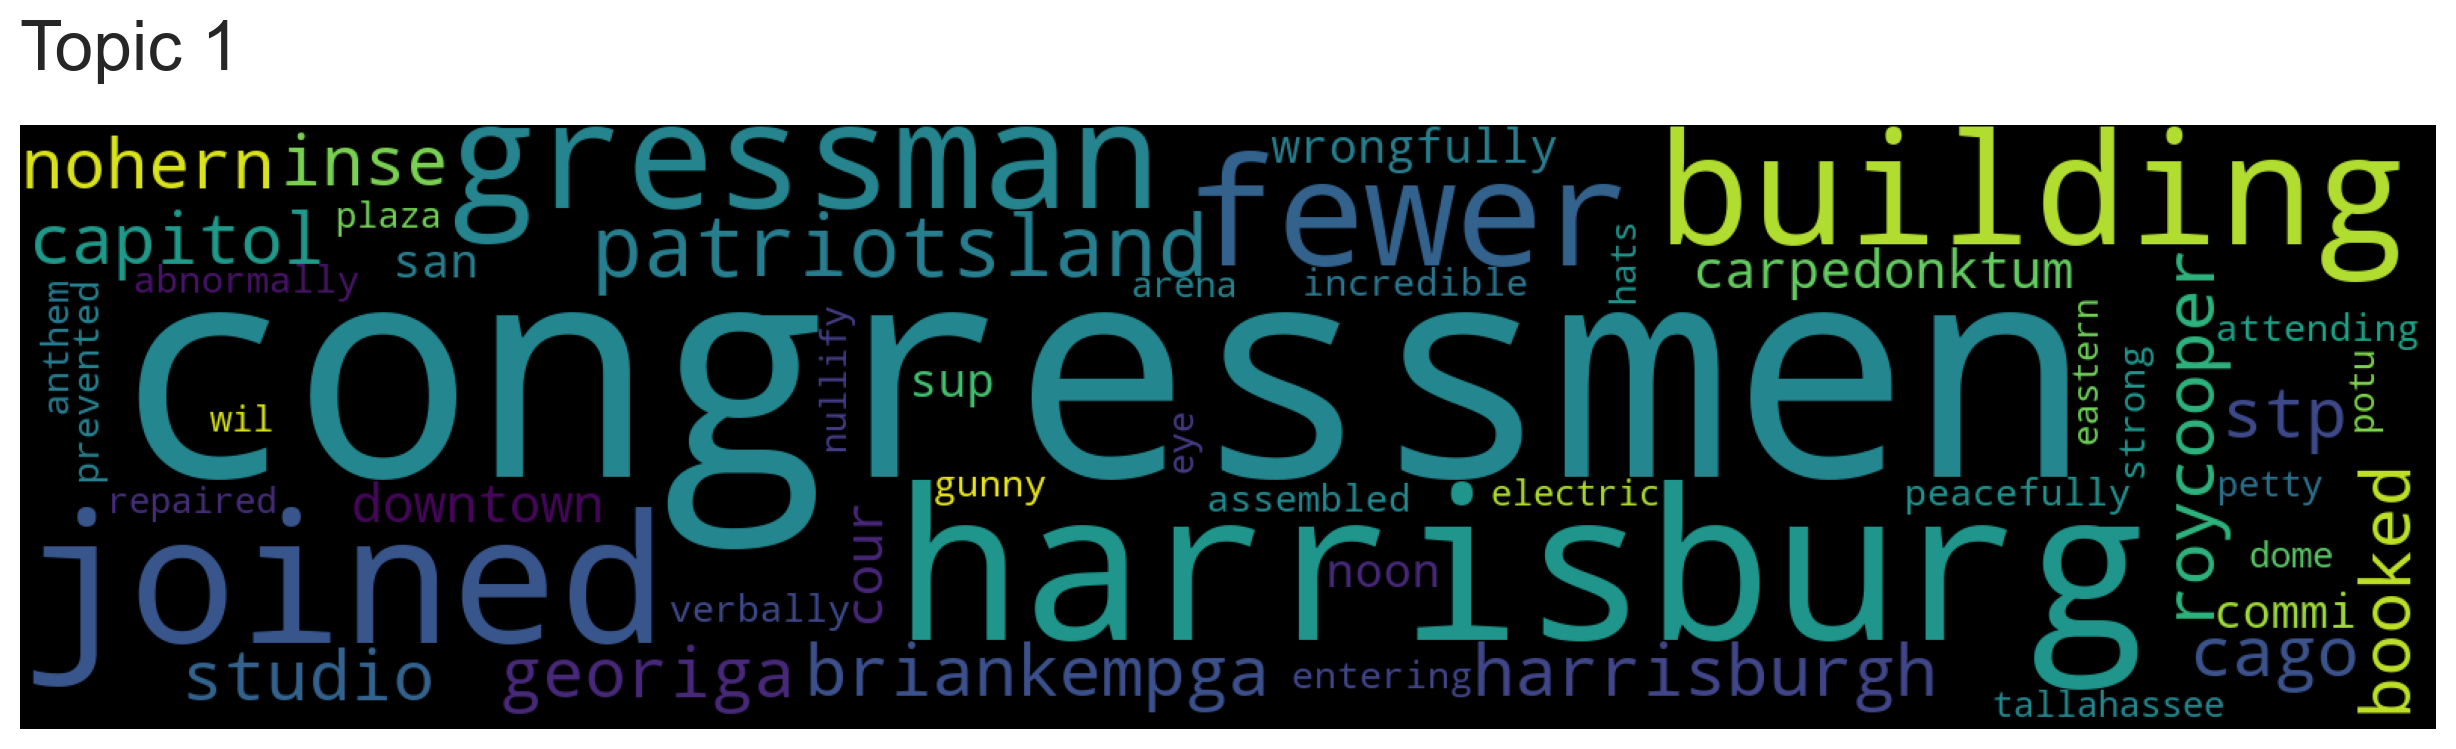

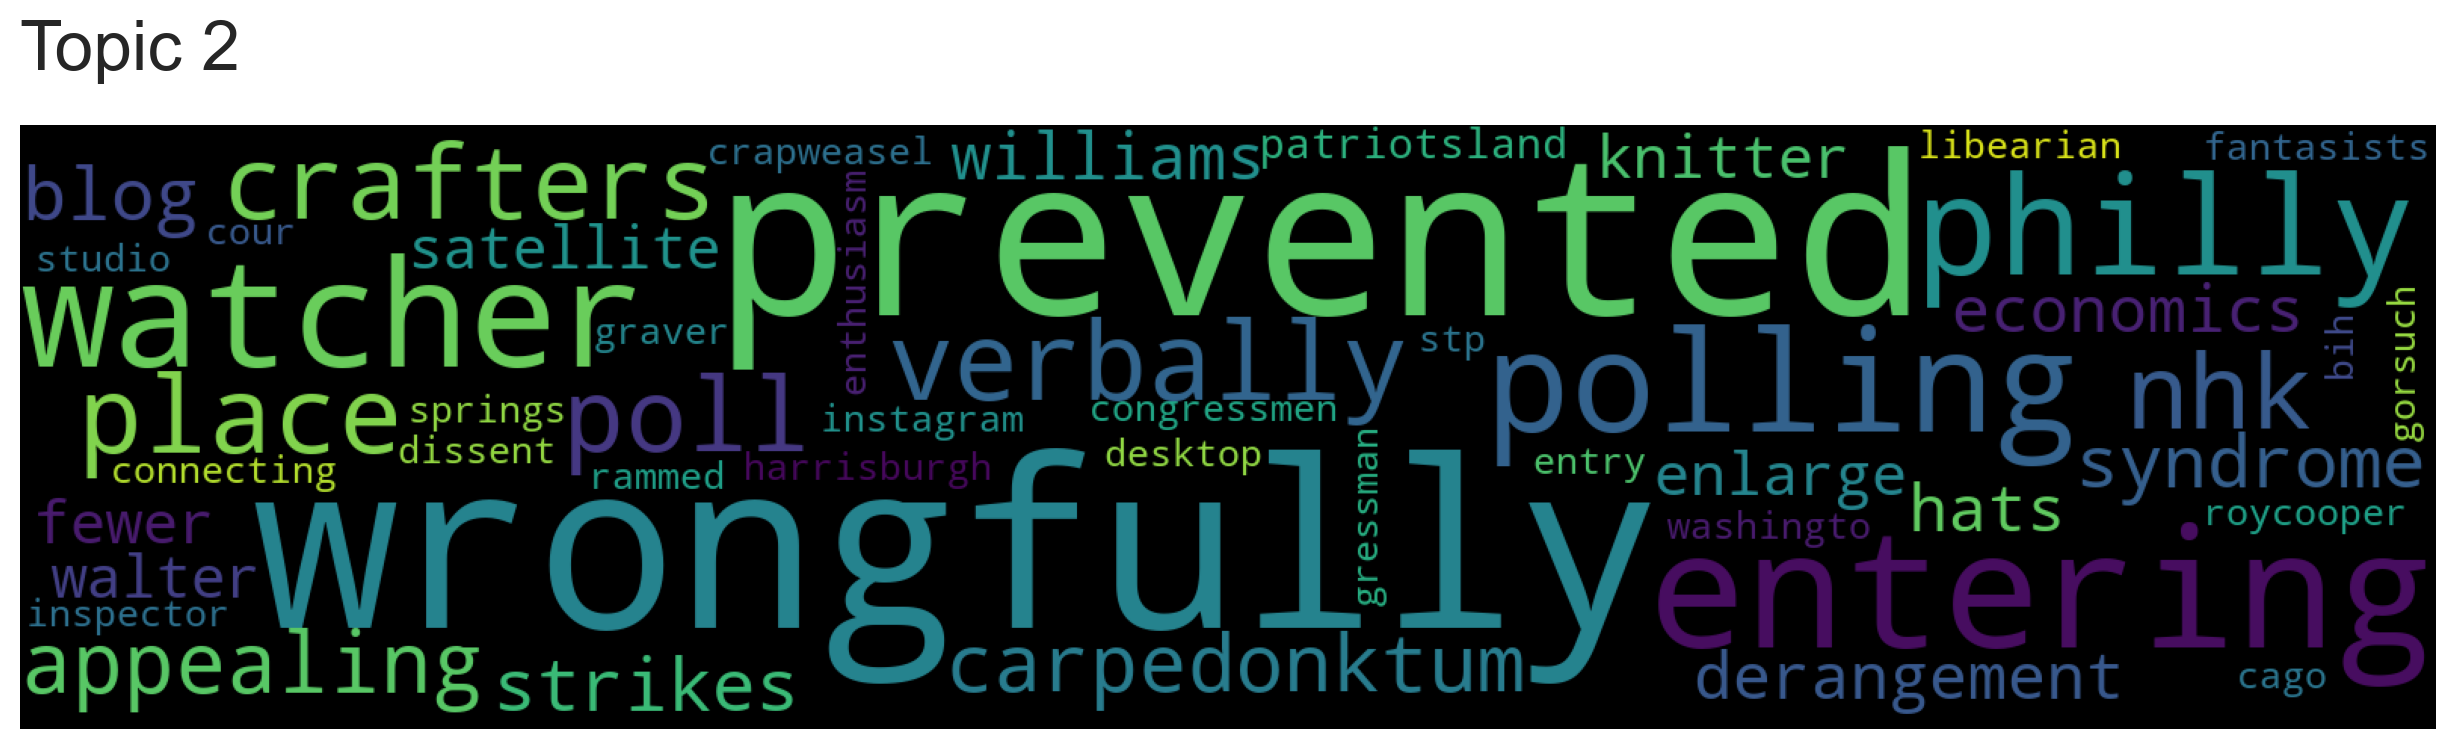

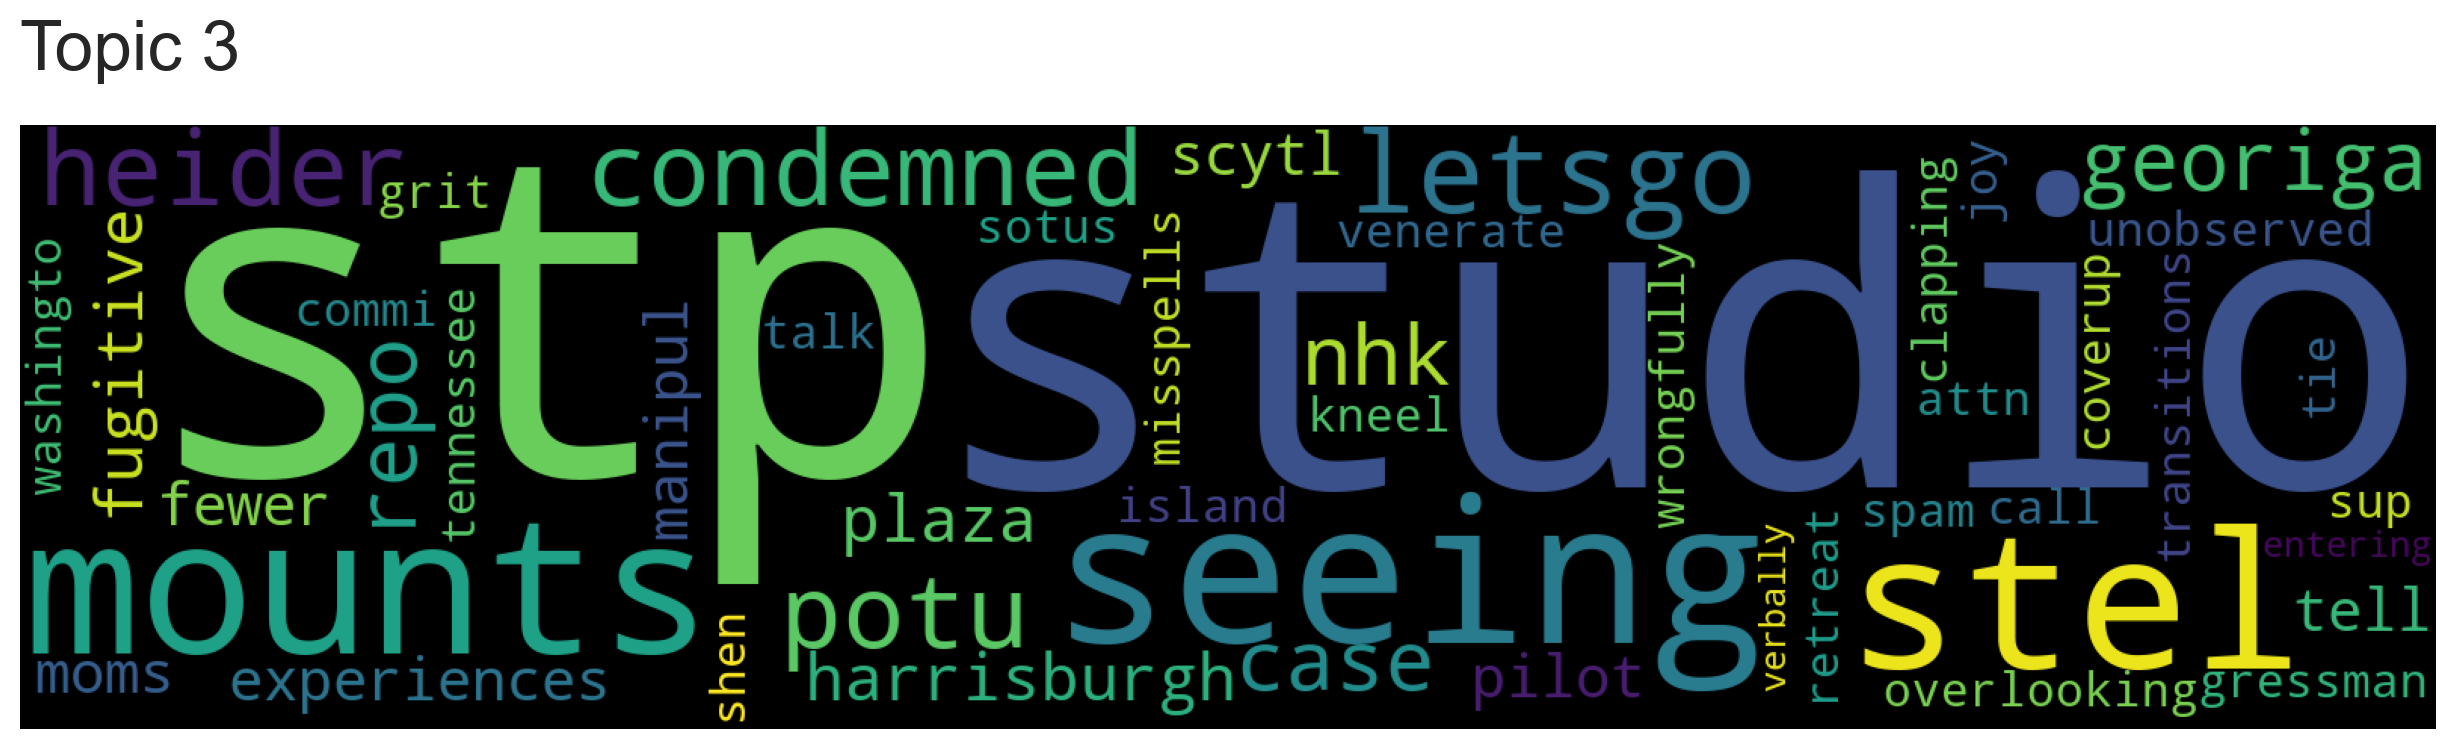

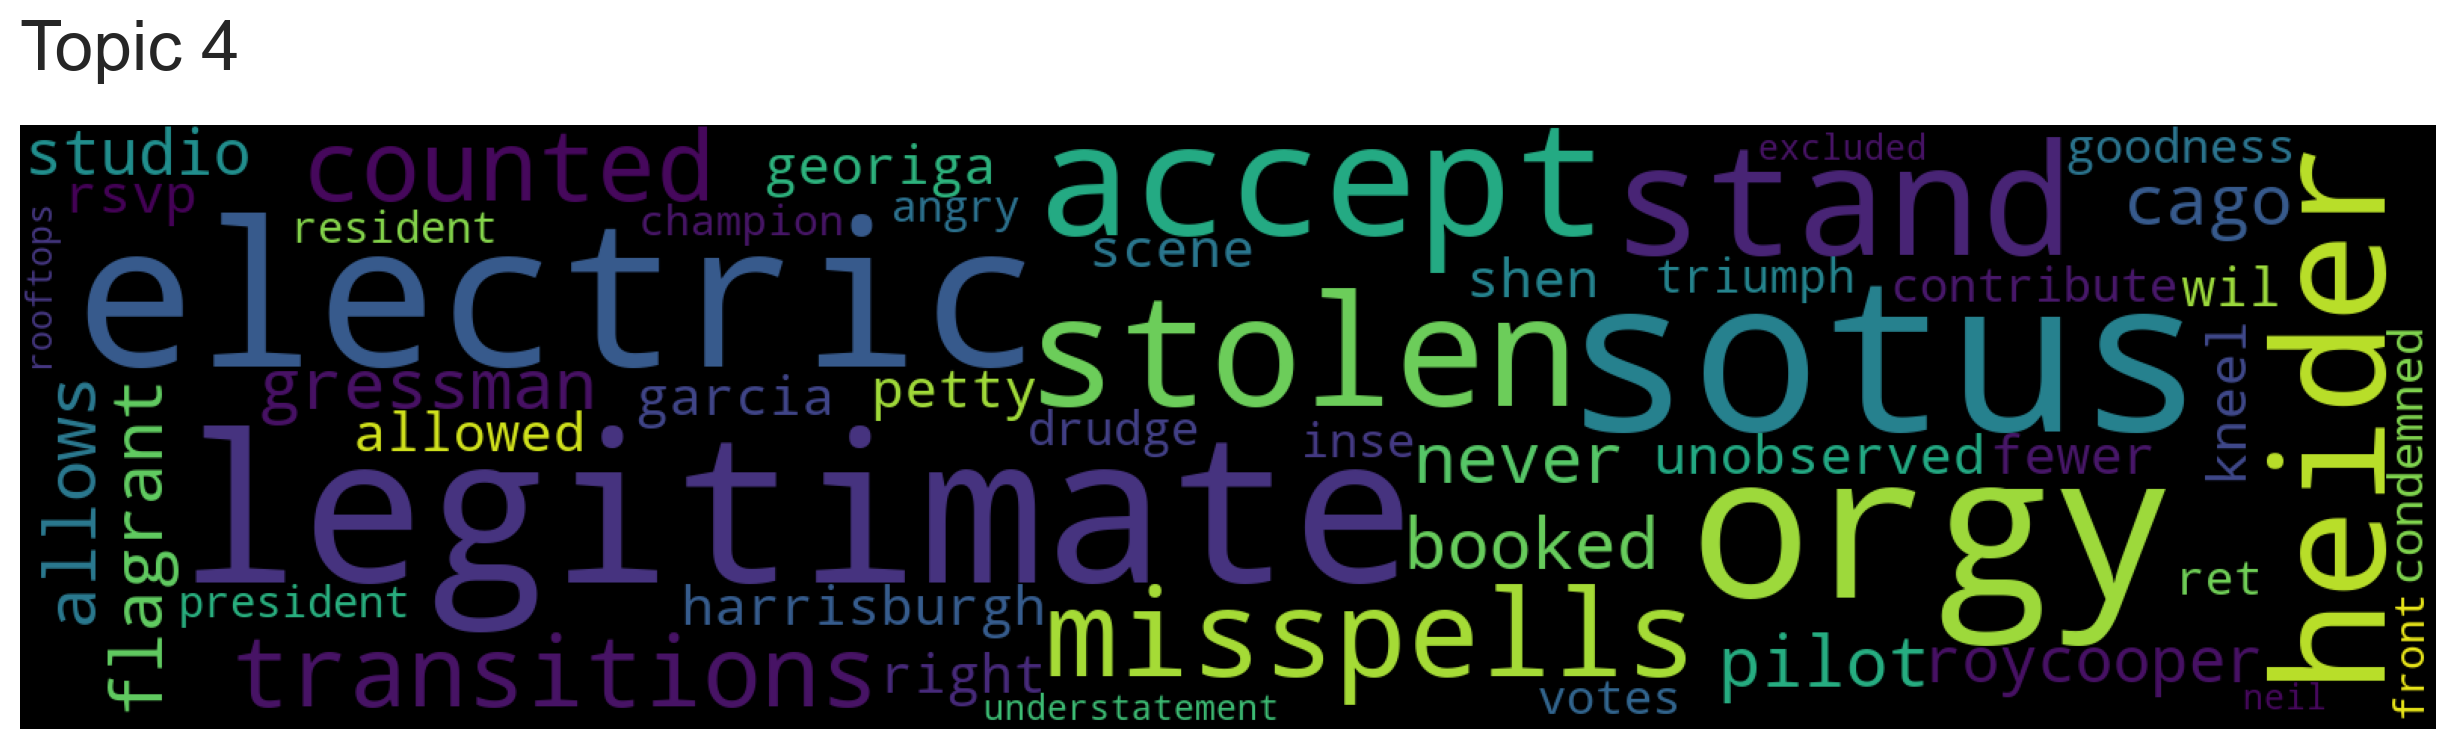

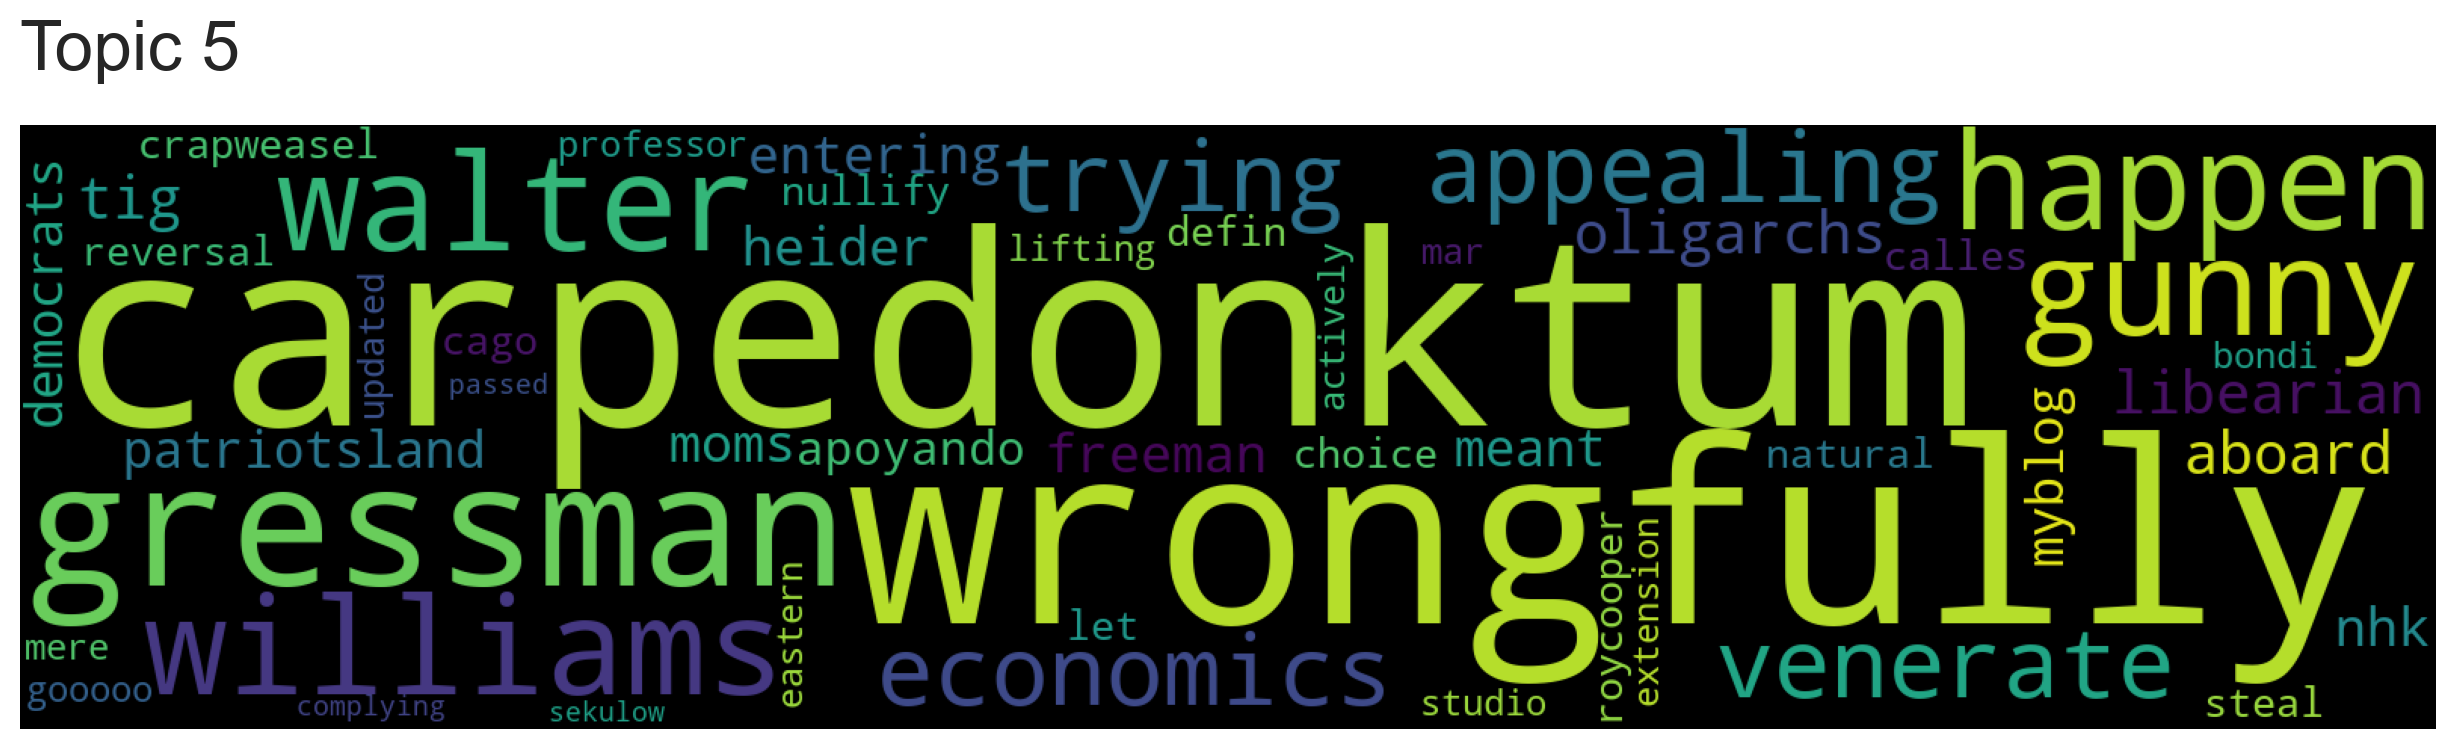

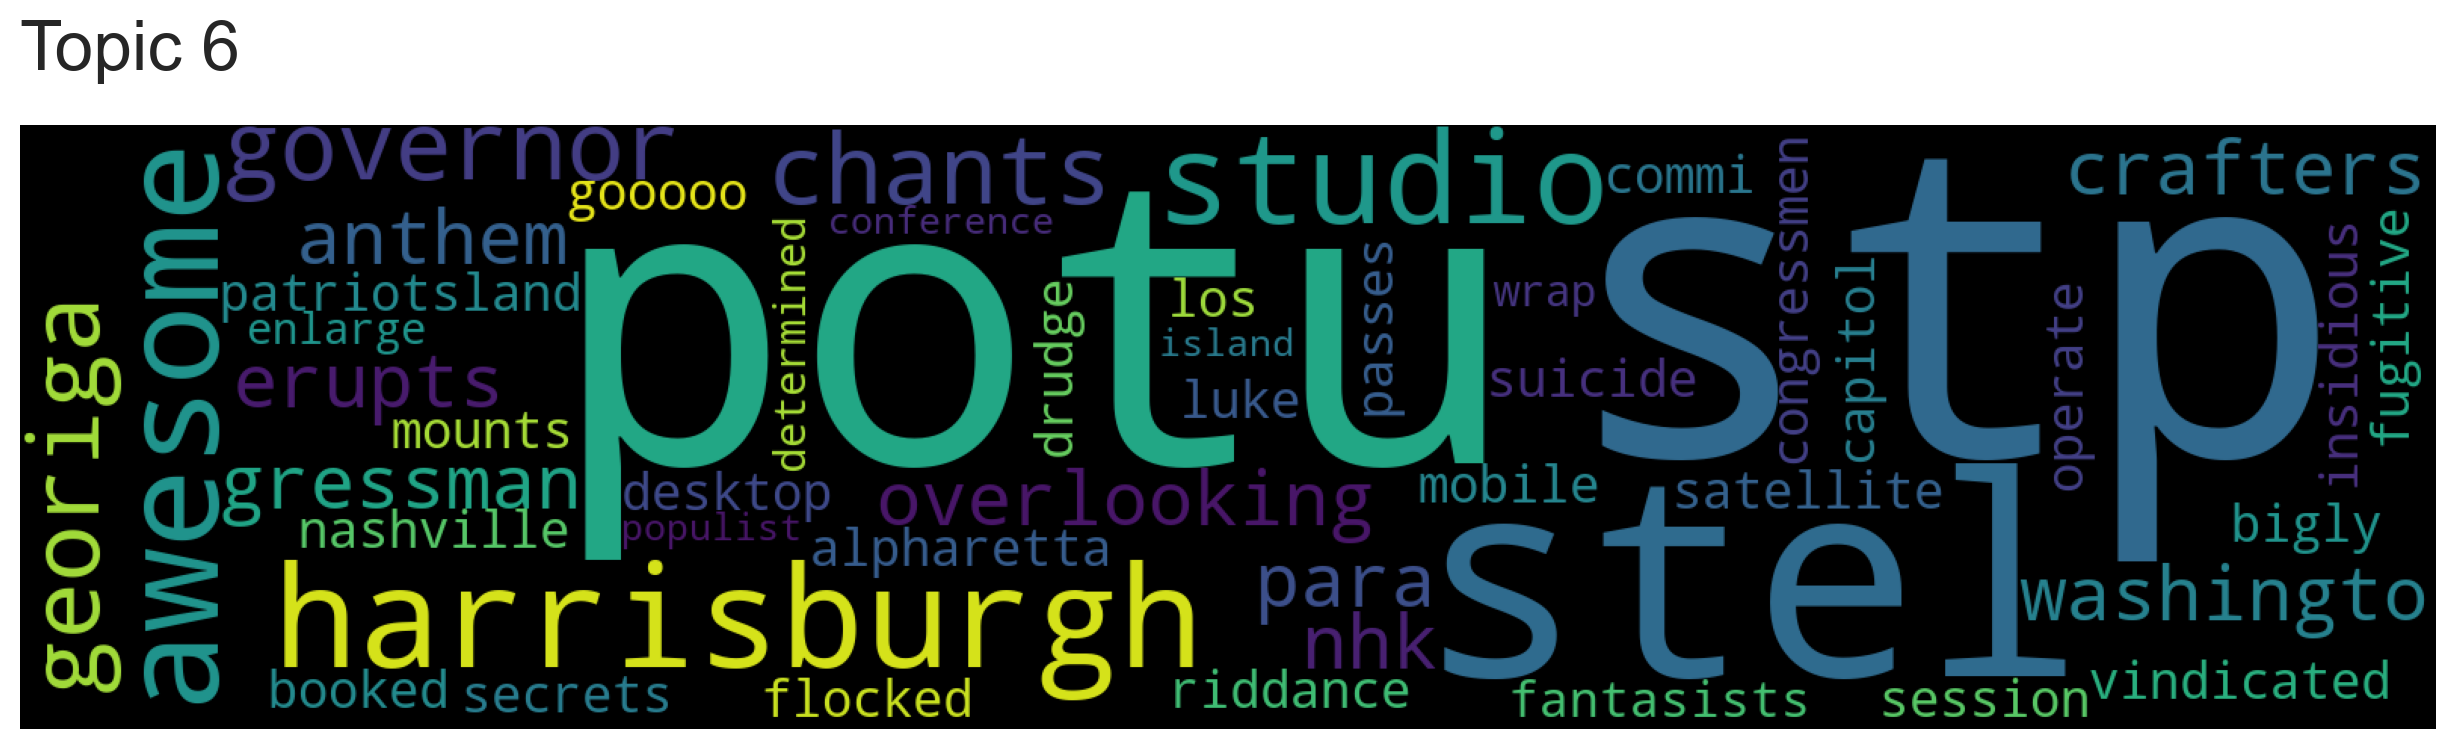

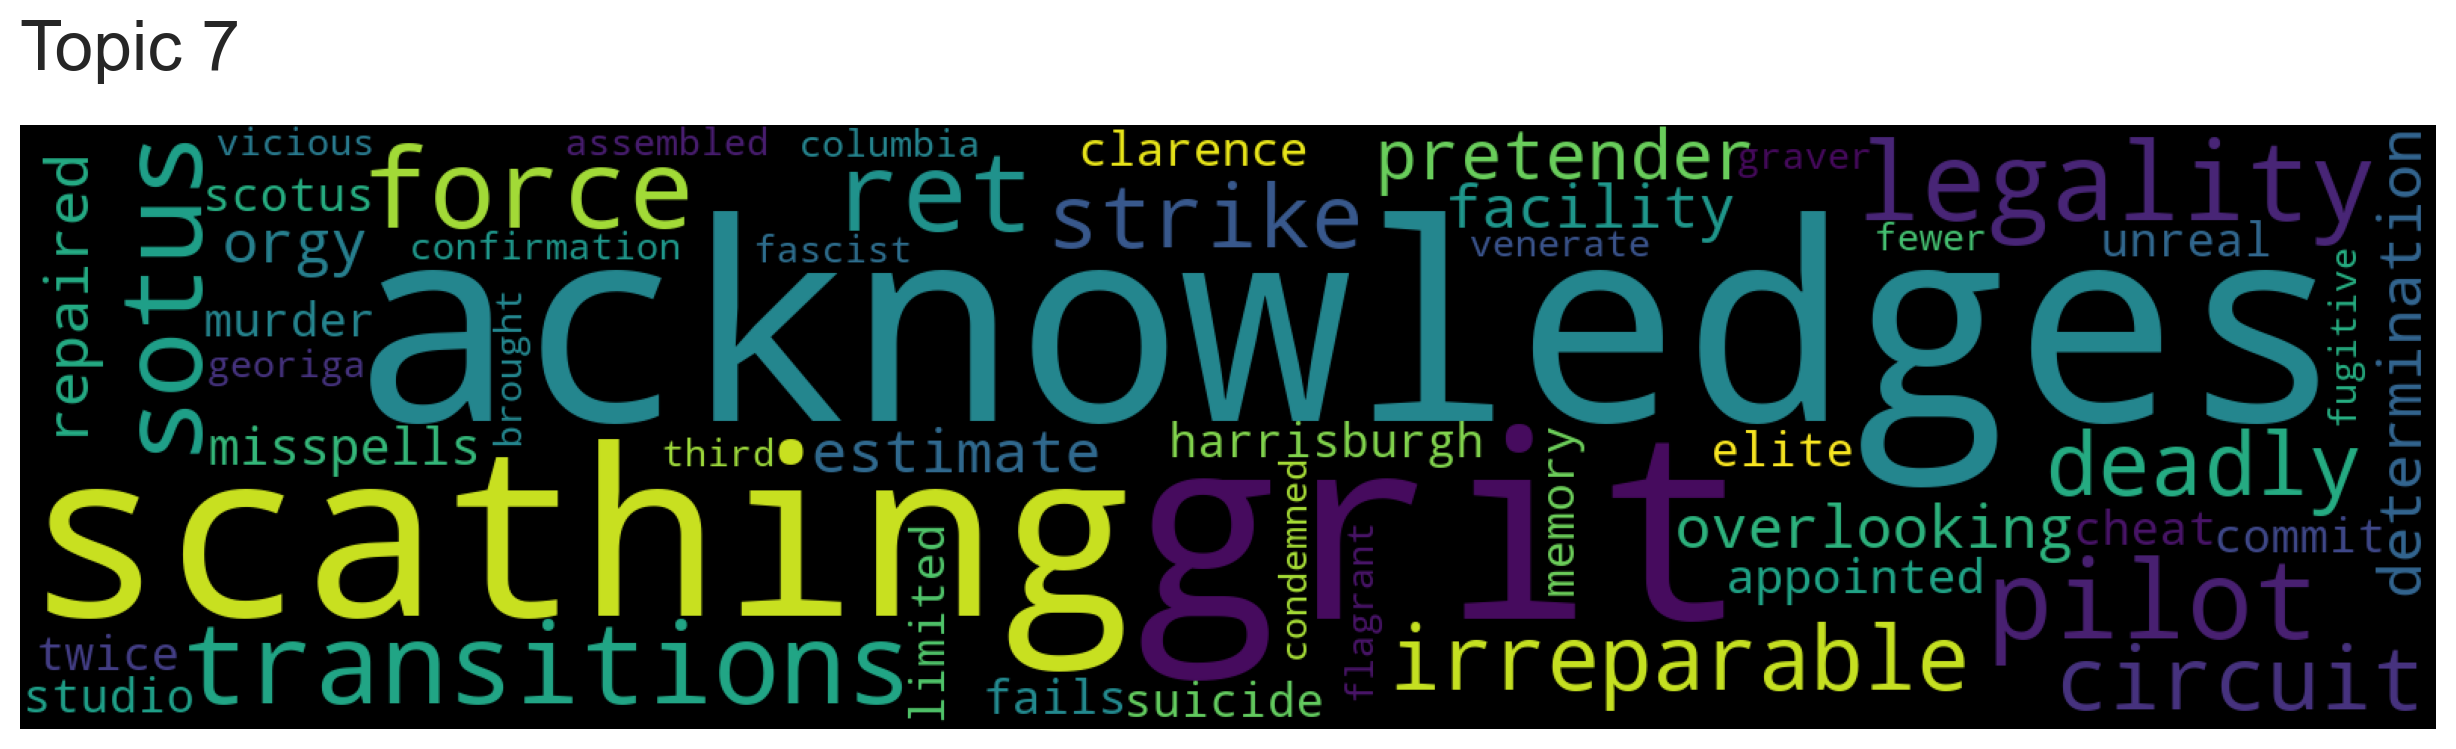

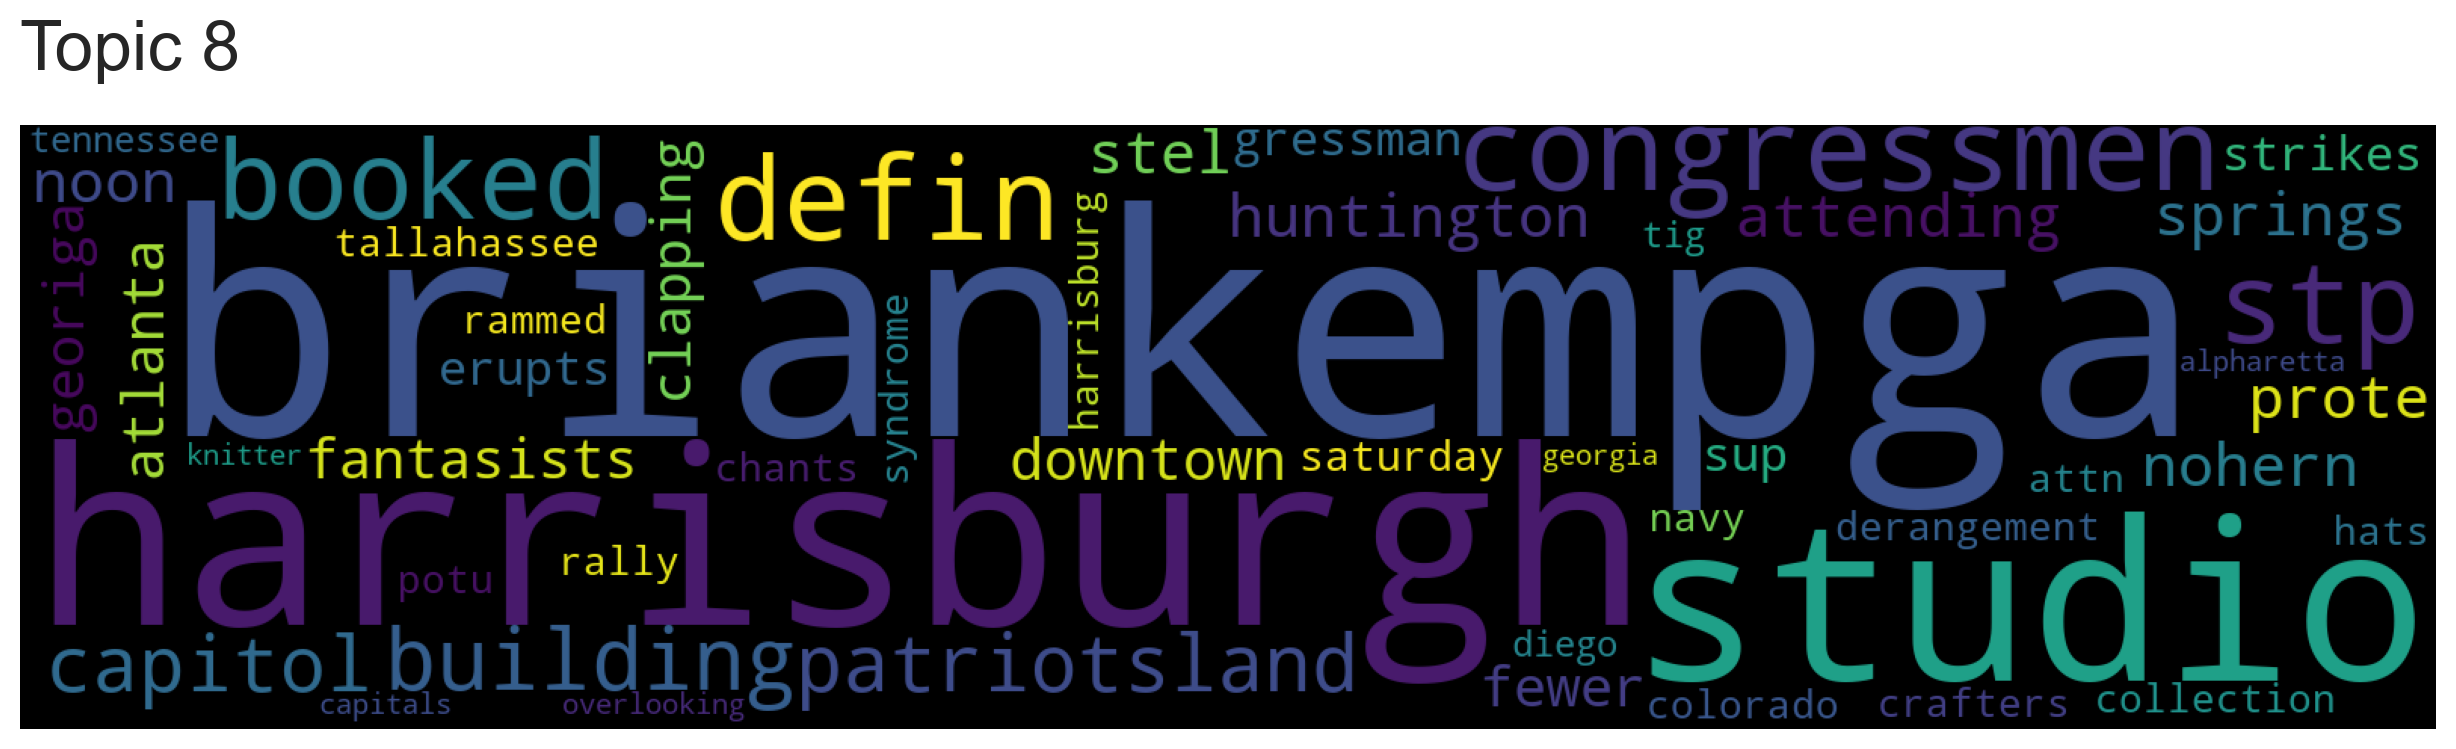

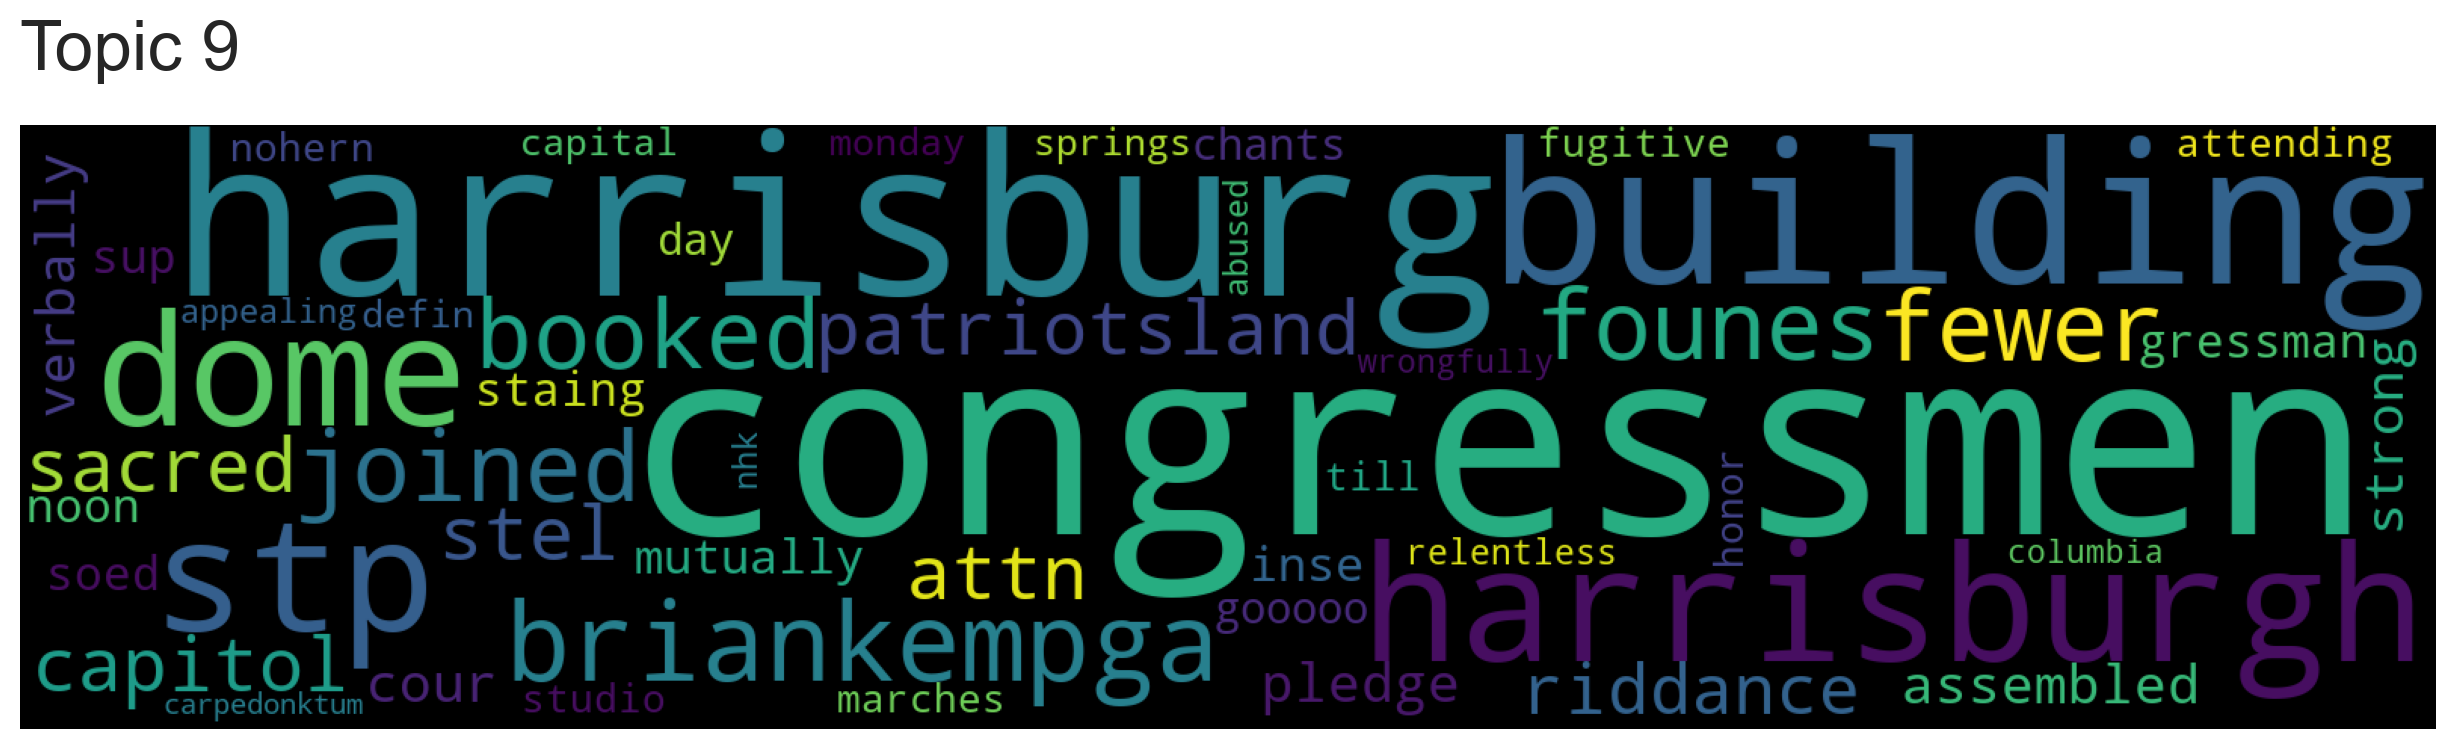

In [32]:
# topic_words, word_scores, topic_scores, topic_numbers = model.
for topic in topics_10:
    model.generate_topic_wordcloud(topic)